In [1]:
import re
from os.path import join
from IPython.display import display

import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data_utils

from lolip.models.torch_utils.archs import *
from lolip.variables import auto_var
from lolip.models.torch_model import TorchModel
from lolip.utils import estimate_local_lip_v2
from params import mnistLip, cifarLip, svhnLip, mnistOtherLips, mnistFixLips, cifarOtherLips
from params import cifarFixLips, svhnOtherLips, resImgFixLips
from utils import params_to_dataframe

TEX_DIR = "./tex_files"

auto_var.set_logging_level(0)

In [2]:
def get_model_name(model_name, hyper=None):
    if 'tulip' in model_name:
        return 3, 'GR'
    elif 'advkld' in model_name:
        return 7, 'AT(KLD)'
    elif 'advce' in model_name:
        return 8, 'AT'
    elif 'pstrades6' in model_name:
        return 21, 'PTRADE(6)'
    elif 'pstrades10' in model_name:
        return 22, 'PTRADE(10)'
    elif 'pstrades' in model_name:
        return 20, 'PTRADE(1)'
    elif 'strades6' in model_name:
        return 11, 'TRADES(6)'
    elif 'strades10' in model_name:
        return 12, 'TRADES(10)'
    elif 'strades' in model_name:
        return 10, 'TRADES(1)'
    elif 'ptrades6' in model_name:
        return 14, 'PTRADE(6/b)'
    elif 'ptrades10' in model_name:
        return 15, 'PTRADE(10/b)'
    elif 'ptrades' in model_name:
        return 13, 'PTRADE(1/b)'
    elif 'trades6' in model_name:
        return 24, 'TRADES(6/b)'
    elif 'trades10' in model_name:
        return 25, 'TRADES(10/b)'
    elif 'trades' in model_name:
        return 23, 'TRADES(1/b)'
    elif 'cure' in model_name:
        return 5, 'CURE'
    elif 'llr' in model_name:
        return 4, 'LLR'
    elif 'gr' in model_name:
        return 2, 'GRv0'
    elif 'kld' in model_name:
        return 1, 'Natural(kld)'
    else:
        return 0, 'Natural'
    
col_name = {
    'trn_acc': 'tr acc',
    'tst_acc': 'ts acc',
    'adv_trn_acc': 'adv tr acc',
    'adv_tst_acc': 'adv ts acc',
    'avg_trn_lip_kl': 'tr lip(KL)',
    'avg_tst_lip_kl': 'ts lip(KL)',
    'avg_trn_lip_1': 'tr lip(1)',
    'avg_tst_lip_1': 'ts lip(1)',
}

def output_latex(df):
    for name, d in df.groupby(["dataset", "arch"]):
        d = d.set_index('loss_name')
        d = d.sort_index(axis=0)
        d.index = [i[1] for i in d.index]
        d = d[['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc', 'avg_trn_lip_1', 'avg_tst_lip_1']]
        d = d.rename(columns=col_name)
        tex = d.to_latex(index=True, float_format="%.2f", column_format="lccccccccc")
        with open(join(TEX_DIR, "_".join(name)+"_tab.tex"), "w") as f:
            f.write(tex)
    print(tex)

def display_results(exp, otherExp=None):
    columns = ['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc', 'avg_trn_lip', 'avg_tst_lip']
    _, _, grid_params, _ = exp()()
    df = params_to_dataframe(grid_params,
                             columns=columns,
                             result_file_dir='./results/experiment01/',
                             logging_level=0)
    for c in ['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc']:
        df[c] *= 100
    if otherExp is not None:
        _, _, grid_params, _ = otherExp()()
        add_df = params_to_dataframe(grid_params,
                                 columns=['avg_trn_lip_1', 'avg_tst_lip_1', 'avg_trn_lip_kl', 'avg_tst_lip_kl'],
                                 result_file_dir='./results/experiment03/',
                                 logging_level=0)

        df = df.merge(add_df, how="left", on=['model', 'dataset', 'attack', 'norm', 'eps', 'random_seed'])
    else:
        df['avg_trn_lip_1'] = np.nan
        df['avg_tst_lip_1'] = np.nan
        df['avg_trn_lip_kl'] = np.nan
        df['avg_tst_lip_kl'] = np.nan

    df['arch'] = df['model'].apply(lambda a: a.split("-")[2])
    df['loss_name'] = df['model'].apply(lambda a: get_model_name(a.split("-")[0] if 'aug' not in a.split("-")[0] else a.split("-")[1]))
    df['gen_gap'] = df['trn_acc'] - df['tst_acc']

    for name, d in df.groupby(["dataset", "arch"]):
        print(name)
        display(d)
    return df

def display_results_fix(exp):
    columns = ['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc', 'avg_trn_lip_1', 'avg_tst_lip_1']
    _, _, grid_params, _ = exp()()
    df = params_to_dataframe(grid_params,
                             columns=columns,
                             result_file_dir='./results/experiment02/',
                             logging_level=0)
    for c in ['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc']:
        df[c] *= 100

    df['arch'] = df['model'].apply(lambda a: a.split("-")[2])
    df['loss_name'] = df['model'].apply(lambda a: get_model_name(a.split("-")[0] if 'aug' not in a.split("-")[0] else a.split("-")[1]))

    for name, d in df.groupby(["dataset", "arch"]):
        print(name)
        display(d)
    return df

In [3]:
df = display_results_fix(mnistFixLips)
output_latex(df)

('mnist', 'CNN001')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name
0,pgd,mnist,0.1,strades6ce-tor-CNN001,inf,0,96.981667,97.07,91.415000,91.31,2.737411,2.752654,CNN001,"(11, TRADE(6))"
1,pgd,mnist,0.1,stradesce-tor-CNN001,inf,0,99.806667,99.26,98.696667,96.60,9.619464,9.690696,CNN001,"(10, TRADE(1))"
2,pgd,mnist,0.1,ce-tor-CNN001,inf,0,100.000000,99.20,60.280000,59.83,66.886009,67.246512,CNN001,"(0, Natural)"
3,pgd,mnist,0.1,tulipce-tor-CNN001,inf,0,99.988333,99.29,94.516667,91.03,26.081958,26.047614,CNN001,"(3, GR)"
4,pgd,mnist,0.1,advce-tor-CNN001,inf,0,99.981667,99.31,99.883333,97.21,8.730167,8.840337,CNN001,"(8, AT)"
5,pgd,mnist,0.1,llrce-tor-CNN001,inf,0,99.998333,99.34,97.725000,92.38,33.917080,34.063950,CNN001,"(4, LLR)"


('mnist', 'CNN002')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name
6,pgd,mnist,0.1,strades6ce-tor-CNN002,inf,0,99.613333,99.59,99.533333,98.73,1.351692,1.360831,CNN002,"(11, TRADE(6))"
7,pgd,mnist,0.1,stradesce-tor-CNN002,inf,0,99.963333,99.58,99.800000,98.10,4.687971,4.741066,CNN002,"(10, TRADE(1))"
8,pgd,mnist,0.1,ce-tor-CNN002,inf,0,100.000000,99.51,85.728333,86.01,23.046890,23.062061,CNN002,"(0, Natural)"
9,pgd,mnist,0.1,tulipce-tor-CNN002,inf,0,99.993333,99.55,96.263333,93.71,20.466134,20.264725,CNN002,"(3, GR)"
10,pgd,mnist,0.1,advce-tor-CNN002,inf,0,99.981667,99.48,99.950000,98.03,6.027635,6.090549,CNN002,"(8, AT)"
11,pgd,mnist,0.1,llrce-tor-CNN002,inf,0,100.000000,99.58,97.878333,95.55,9.077055,9.068392,CNN002,"(4, LLR)"


\begin{tabular}{lccccccccc}
\toprule
{} &  tr acc &  ts acc &  adv tr acc &  adv ts acc &  tr lip(1) &  ts lip(1) \\
\midrule
Natural  &  100.00 &   99.51 &       85.73 &       86.01 &      23.05 &      23.06 \\
GR       &   99.99 &   99.55 &       96.26 &       93.71 &      20.47 &      20.26 \\
LLR      &  100.00 &   99.58 &       97.88 &       95.55 &       9.08 &       9.07 \\
AT       &   99.98 &   99.48 &       99.95 &       98.03 &       6.03 &       6.09 \\
TRADE(1) &   99.96 &   99.58 &       99.80 &       98.10 &       4.69 &       4.74 \\
TRADE(6) &   99.61 &   99.59 &       99.53 &       98.73 &       1.35 &       1.36 \\
\bottomrule
\end{tabular}



In [4]:
#df = display_results(cifarLip, cifarOtherLips)
df = display_results_fix(cifarFixLips)
output_latex(df)

('cifar10', 'WRN_40_10')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name
0,pgd,cifar10,0.031,ce-tor-WRN_40_10,inf,0,100.000,88.62,0.000,0.00,347.441545,356.456262,WRN_40_10,"(0, Natural)"
1,pgd,cifar10,0.031,tulipce-tor-WRN_40_10,inf,0,99.714,71.68,22.950,13.73,33.186252,33.265875,WRN_40_10,"(3, GR)"
2,pgd,cifar10,0.031,stradesce-tor-WRN_40_10,inf,0,100.000,81.61,99.996,38.06,24.386368,30.786882,WRN_40_10,"(10, TRADE(1))"
3,pgd,cifar10,0.031,strades6ce-tor-WRN_40_10,inf,0,99.794,78.34,99.752,37.33,11.143698,19.788508,WRN_40_10,"(11, TRADE(6))"
4,pgd,cifar10,0.031,advce-tor-WRN_40_10,inf,0,99.982,74.00,99.694,33.09,16.087958,16.896749,WRN_40_10,"(8, AT)"
5,pgd,cifar10,0.031,llrce-tor-WRN_40_10,inf,0,100.000,89.12,22.532,15.83,57.875086,61.140412,WRN_40_10,"(4, LLR)"


('cifar10', 'tor')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name
6,pgd,cifar10,0.031,aug01-ce-tor-WRN_40_10,inf,0,100.000,93.81,0.002,0.00,418.622176,425.708713,tor,"(0, Natural)"
7,pgd,cifar10,0.031,aug01-tulipce-tor-WRN_40_10,inf,0,94.904,80.74,25.264,21.32,28.566197,28.527540,tor,"(3, GR)"
8,pgd,cifar10,0.031,aug01-strades6ce-tor-WRN_40_10,inf,0,98.928,84.46,91.234,48.58,10.059369,13.048935,tor,"(11, TRADE(6))"
9,pgd,cifar10,0.031,aug01-stradesce-tor-WRN_40_10,inf,0,99.760,84.96,88.260,43.66,25.408692,28.009600,tor,"(10, TRADE(1))"
10,pgd,cifar10,0.031,aug01-advce-tor-WRN_40_10-lrem2,inf,0,99.842,83.51,93.450,43.51,24.322157,26.230431,tor,"(8, AT)"
11,pgd,cifar10,0.031,aug01-llrce-tor-WRN_40_10,inf,0,100.000,92.48,20.156,18.23,65.973042,70.279050,tor,"(4, LLR)"


\begin{tabular}{lccccccccc}
\toprule
{} &  tr acc &  ts acc &  adv tr acc &  adv ts acc &  tr lip(1) &  ts lip(1) \\
\midrule
Natural  &  100.00 &   93.81 &        0.00 &        0.00 &     418.62 &     425.71 \\
GR       &   94.90 &   80.74 &       25.26 &       21.32 &      28.57 &      28.53 \\
LLR      &  100.00 &   92.48 &       20.16 &       18.23 &      65.97 &      70.28 \\
AT       &   99.84 &   83.51 &       93.45 &       43.51 &      24.32 &      26.23 \\
TRADE(1) &   99.76 &   84.96 &       88.26 &       43.66 &      25.41 &      28.01 \\
TRADE(6) &   98.93 &   84.46 &       91.23 &       48.58 &      10.06 &      13.05 \\
\bottomrule
\end{tabular}



In [5]:
df = display_results(svhnLip, svhnOtherLips)
output_latex(df)

('svhn', 'WRN_40_10')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip,avg_tst_lip,avg_trn_lip_1,avg_tst_lip_1,avg_trn_lip_kl,avg_tst_lip_kl,arch,loss_name,gen_gap
0,pgd,svhn,0.031,ce-tor-WRN_40_10,inf,0,0.999986,0.958474,0.034290,0.024700,48.150909,48.617779,149.078116,149.817892,0.045008,0.738318,WRN_40_10,"(0, Natural)",0.041512
1,pgd,svhn,0.031,strades6ce-tor-WRN_40_10,inf,0,0.971853,0.918331,0.819990,0.581131,1.166008,1.597083,3.849708,5.199245,0.001586,0.005057,WRN_40_10,"(11, TRADE(6))",0.053521
2,pgd,svhn,0.031,strades10ce-tor-WRN_40_10,inf,0,0.946299,0.903542,0.795419,0.575791,0.805747,1.146986,NaN,NaN,NaN,NaN,WRN_40_10,"(12, TRADE(10))",0.042757
3,pgd,svhn,0.031,curece-tor-WRN_40_10,inf,0,0.910029,0.907230,0.195585,0.190535,5.777227,5.557568,15.955604,15.261774,0.058604,0.055697,WRN_40_10,"(4, CURE)",0.002800
4,pgd,svhn,0.031,advce-tor-WRN_40_10-lrem2,inf,0,0.952005,0.924478,0.724682,0.550860,3.642485,3.780584,12.568644,13.025192,0.008108,0.013778,WRN_40_10,"(8, AT(CE))",0.027527
5,pgd,svhn,0.031,llrce-tor-WRN_40_10,inf,0,0.999973,0.951214,0.345632,0.306238,17.138792,18.932571,53.669503,59.484519,0.000012,0.183467,WRN_40_10,"(3, LLR)",0.048759


In [3]:
def display_results_2(exp):
    columns = ['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc', 'avg_trn_lip_1', 'avg_tst_lip_1']
    _, _, grid_params, _ = exp()()
    df = params_to_dataframe(grid_params,
                             columns=columns,
                             result_file_dir='./results/restrictedImgnet3/',
                             logging_level=0)
    for c in ['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc']:
        df[c] *= 100

    df['arch'] = df['model'].apply(lambda a: a.split("-")[2])
    df['loss_name'] = df['model'].apply(lambda a: get_model_name(a.split("-")[0] if 'aug' not in a.split("-")[0] else a.split("-")[1]))

    for name, d in df.groupby(["dataset", "arch"]):
        print(name)
        display(d)
    return df

In [16]:
df = display_results_2(resImgFixLips)
for name, d in df.groupby(["dataset", "arch"]):
    output_latex(d)

('resImgnet112v3', 'ResNet152')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name
0,pgd,resImgnet112v3,0.005,ce-tor-ResNet152-adambs128,inf,0,97.327234,93.507389,9.725779,10.482759,20282.500337,26771.974724,ResNet152,"(0, Natural)"
1,pgd,resImgnet112v3,0.005,stradesce-tor-ResNet152-adambs128,inf,0,95.698900,90.975369,84.621801,79.133005,1653.596230,1239.129224,ResNet152,"(10, TRADES(1))"
2,pgd,resImgnet112v3,0.005,strades6ce-tor-ResNet152-adambs128,inf,0,92.361531,88.384236,86.460031,81.733990,182.940675,159.039895,ResNet152,"(11, TRADES(6))"
3,pgd,resImgnet112v3,0.005,advce-tor-ResNet152-adambs128,inf,0,96.230815,90.955665,90.833683,82.709360,4010.856099,4251.504872,ResNet152,"(8, AT)"
4,pgd,resImgnet112v3,0.005,sllr36ce-tor-ResNet152-adambs128,inf,0,98.271568,93.133005,52.337942,52.876847,34187.745373,35555.325547,ResNet152,"(4, LLR)"
5,pgd,resImgnet112v3,0.005,tulipce-tor-ResNet152-adambs128,inf,0,88.927557,86.778325,58.161848,59.201970,1217.487514,921.098742,ResNet152,"(3, GR)"


('resImgnet112v3', 'ResNet50')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,arch,loss_name
6,pgd,resImgnet112v3,0.005,ce-tor-ResNet50-adambs128,inf,0,97.800177,93.438424,7.611698,8.266010,18643.824318,21993.865732,ResNet50,"(0, Natural)"
7,pgd,resImgnet112v3,0.005,stradesce-tor-ResNet50-adambs128,inf,0,97.393190,92.266010,86.544221,79.891626,2148.246010,2144.655471,ResNet50,"(10, TRADES(1))"
8,pgd,resImgnet112v3,0.005,strades6ce-tor-ResNet50-adambs128,inf,0,93.338067,88.916256,87.425703,82.118227,202.860269,200.902166,ResNet50,"(11, TRADES(6))"
9,pgd,resImgnet112v3,0.005,strades10ce-tor-ResNet50-adambs128,inf,0,93.107221,88.344828,88.356845,82.532020,137.674062,144.246204,ResNet50,"(12, TRADES(10))"
10,pgd,resImgnet112v3,0.005,advce-tor-ResNet50-adambs128,inf,0,96.222279,90.325123,90.473253,82.216749,283.740092,287.968701,ResNet50,"(8, AT)"
11,pgd,resImgnet112v3,0.005,sllr36ce-tor-ResNet50-adambs128,inf,0,98.759253,93.438424,52.751913,52.541872,3862.719966,4795.655284,ResNet50,"(4, LLR)"
12,pgd,resImgnet112v3,0.005,tulipce-tor-ResNet50-adambs128,inf,0,91.121173,87.950739,53.452597,54.807882,816.054463,854.493511,ResNet50,"(3, GR)"


\begin{tabular}{lccccccccc}
\toprule
{} &  tr acc &  ts acc &  adv tr acc &  adv ts acc &  tr lip(1) &  ts lip(1) \\
\midrule
Natural   &   97.33 &   93.51 &        9.73 &       10.48 &   20282.50 &   26771.97 \\
GR        &   88.93 &   86.78 &       58.16 &       59.20 &    1217.49 &     921.10 \\
LLR       &   98.27 &   93.13 &       52.34 &       52.88 &   34187.75 &   35555.33 \\
AT        &   96.23 &   90.96 &       90.83 &       82.71 &    4010.86 &    4251.50 \\
TRADES(1) &   95.70 &   90.98 &       84.62 &       79.13 &    1653.60 &    1239.13 \\
TRADES(6) &   92.36 &   88.38 &       86.46 &       81.73 &     182.94 &     159.04 \\
\bottomrule
\end{tabular}

\begin{tabular}{lccccccccc}
\toprule
{} &  tr acc &  ts acc &  adv tr acc &  adv ts acc &  tr lip(1) &  ts lip(1) \\
\midrule
Natural    &   97.80 &   93.44 &        7.61 &        8.27 &   18643.82 &   21993.87 \\
GR         &   91.12 &   87.95 &       53.45 &       54.81 &     816.05 &     854.49 \\
LLR        &   98.76 & 

In [15]:
a = joblib.load("./results/restrictedImgnet2/pgd-resImgnet112v3-0.005-advce-tor-ResNet152-adambs128-inf-0.pkl")
a

{'model_path': './models/pgd-resImgnet112v3-0.005-advce-tor-ResNet152-adambs128-inf-0-ep0070.pt',
 'trn_acc': 0.9623081459409967,
 'tst_acc': 0.9095566502463054,
 'adv_trn_acc': 0.9083368251160048,
 'adv_tst_acc': 0.8270935960591133,
 'avg_trn_lip_1': 4010.8560992064977,
 'avg_tst_lip_1': 4251.504871760026,
 'running_time': 39498.02967143059}

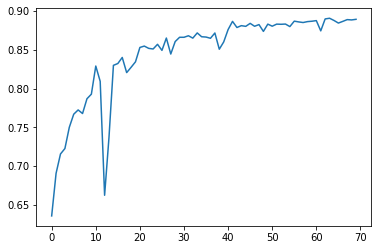

In [14]:
plt.plot([i['tst_acc'] for i in a['history']])

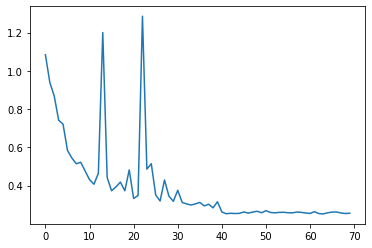

In [17]:
a = joblib.load("./results/restrictedImgnet/pgd-resImgnet112v3-0.005-stradesce-tor-ResNet50-adambs128-inf-0.pkl")
plt.plot([i['tst_loss'] for i in a['history']])

In [3]:
from scipy.special import softmax

def get_arch(path):
    return path.split("-")[path.split("-").index('tor')+1]

def get_ds(path):
    return path.split("-")[1]

def predict_real(model, X):
    X = X.transpose(0, 3, 1, 2)
    dataset = data_utils.TensorDataset(torch.from_numpy(X).float())
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)
    ret = []
    for [x] in loader:
        ret.append(model(x.to('cuda')).detach().cpu().numpy())
    return np.concatenate(ret, axis=0)

def calc_lip(model, X, Xp, top_norm, btm_norm):
    top = np.linalg.norm(predict_real(model, X)-predict_real(model, Xp), ord=top_norm, axis=1)
    down = np.linalg.norm(X.reshape(len(Xp), -1)-Xp.reshape(len(Xp), -1), ord=btm_norm, axis=1)
    return top / (down+1e-6)

def get_lip(model, X, top_norm=2, btm_norm=2, epsilon=1.0):
    lip = estimate_local_lip_v2(model, X, top_norm=top_norm, btm_norm=btm_norm, epsilon=epsilon)
    lip_ = calc_lip(model, X, lip, top_norm=top_norm, btm_norm=btm_norm)
    return lip_

class ModelWrapper():
    def __init__(self, model):
        self.model = model
    def predict_proba(self, X):
        return softmax(predict_real(self.model, X), axis=1)
    def predict_real(self, X):
        return predict_real(self.model, X)
    def predict(self, X):
        return predict_real(self.model, X).argmax(axis=1)
    
cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
model_path = "./models/pgd-cifar10-0.031-advce-tor-WRN_40_10-inf-0.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()
model = ModelWrapper(model)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))

In [11]:
pred = model.predict_proba(trnX)
log_loss = np.array([np.log(pred[i][trny[i]]) for i in range(len(pred))])

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 1.0000e+01,
        1.5000e+01, 2.2000e+01, 5.0000e+01, 8.7000e+01, 4.9811e+04]),
 array([-1.5260077 , -1.3734069 , -1.2208061 , -1.0682054 , -0.9156046 ,
        -0.7630038 , -0.61040306, -0.4578023 , -0.30520153, -0.15260077,
         0.        ], dtype=float32),
 <a list of 10 Patch objects>)

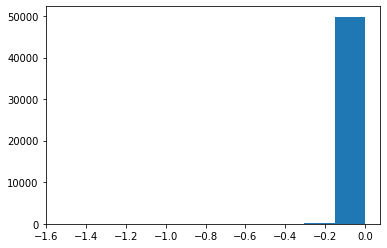

In [13]:
plt.hist(log_loss)

In [16]:
model_path = "./models/pgd-cifar10-0.031-strades6ce-tor-WRN_40_10-inf-0-ep0120.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path), strict=False)
model.eval()
model.cuda()
model = ModelWrapper(model)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))
pred = model.predict_proba(trnX)
log_loss2 = np.array([np.log(pred[i][trny[i]]) for i in range(len(pred))])

(array([   18.,   115.,   426.,  1486.,  4644.,  8722.,  4822., 12827.,
        10287.,  6653.]),
 array([-13.443183  , -12.117084  , -10.790984  ,  -9.464885  ,
         -8.138785  ,  -6.8126855 ,  -5.486586  ,  -4.1604867 ,
         -2.834387  ,  -1.5082875 ,  -0.18218805], dtype=float32),
 <a list of 10 Patch objects>)

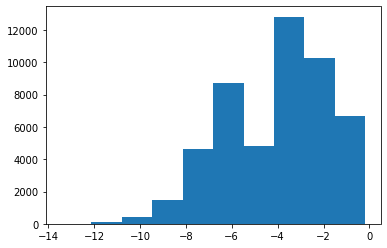

In [17]:
plt.hist(log_loss2)

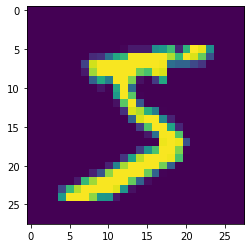

In [10]:
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", 'mnist')
plt.imshow(trnX[0, :, :, 0])

In [12]:
from scipy import fftpack
im = trnX[0, :, :, 0]
im_fft = fftpack.fft2(im)

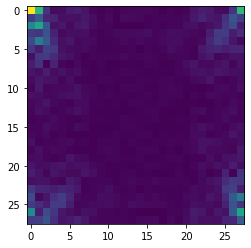

In [16]:
plt.imshow(np.abs(im_fft))

In [4]:
from lolip.utils import estimate_local_mse
model_path = "./models/pgd-cifar10-0.031-aug01-ce-tor-WRN_40_10-inf-0-ep0120.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()
model.cuda()
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))
ret = estimate_local_mse(model, trnX[:100])
print(ret[0])

12.135422058105469


In [280]:
from lolip.attacks.torch.projected_gradient_descent import ProjectedGradientDescent
n = 10000
i = 2
nb_iter=10
eps = 0.05
attack_model = ProjectedGradientDescent(
    model_fn=model.model,
    norm=np.inf,
    eps=eps,
    eps_iter=eps*2/nb_iter,
    nb_iter=nb_iter,
)
adv_tstX = attack_model.perturb(tstX[:n], tsty[:n])
pred = model.predict_proba(tstX[:n])
advpred = model.predict_proba(adv_tstX[:n])
proba = np.array([pred[i][tsty[i]] for i in range(n)])
advproba = np.array([advpred[i][tsty[i]] for i in range(n)])

In [274]:
robust = (advpred.argmax(1) == tsty)
np.where(np.logical_and(proba[robust] < 0.95, proba[robust] >0))
np.where(proba[robust] <= 0.99)

(array([], dtype=int64),)

In [265]:
proba[robust]

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

W0106 15:42:14.924072 140719580231488 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true class: 8
prediction: 8, proba: 0.7208942174911499
prediction: 2, proba: 1.0


[]

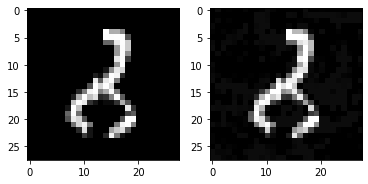

In [271]:
i=582
#i=78
print(f"true class: {int(tsty[i])}")
print(f"prediction: {int(pred.argmax(1)[i])}, proba: {pred.max(1)[i]}")
print(f"prediction: {int(advpred.argmax(1)[i])}, proba: {advpred.max(1)[i]}")

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(np.concatenate([tstX[i], tstX[i], tstX[i]], axis=2))
f.add_subplot(1, 2, 2)
plt.imshow(np.concatenate([adv_tstX[i], adv_tstX[i], adv_tstX[i]], axis=2))
plt.plot()

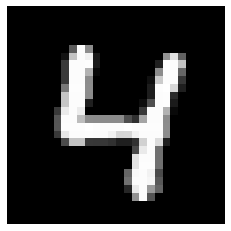

In [215]:
plt.axis('off')
plt.imshow(np.concatenate([tstX[i], tstX[i], tstX[i]], axis=2))
#plt.imshow(np.concatenate([adv_tstX[i], adv_tstX[i], adv_tstX[i]], axis=2))
plt.savefig("./figs/mnist_img2.png", transparent=True)

In [122]:
model_path = "./models/pgd-cifar10-0.031-ce-tor-WRN_40_10-inf-0.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()
model = ModelWrapper(model)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))

a = joblib.load("./results/experiment03/pgd-cifar10-0.031-ce-tor-WRN_40_10-inf-0.pkl")

In [123]:
n = 100
pred = model.predict_proba(tstX[:n])
advpred = model.predict_proba(a['tst_lip_1_pert'][:n])
proba = np.array([pred[i][tsty[i]] for i in range(n)])
advproba = np.array([advpred[i][tsty[i]] for i in range(n)])

print(sorted([(p, i) for i, p in enumerate(proba - advproba)])[::-1])
#print(proba)
#print(advproba)

[(0.91781914, 71), (0.7050022, 78), (0.627071, 87), (0.4679357, 20), (0.19889718, 10), (0.16712534, 47), (0.112924755, 49), (0.10954493, 81), (0.05335039, 85), (0.03948349, 91), (0.013468802, 22), (0.011327028, 32), (0.0032605529, 6), (0.0013139844, 53), (0.000441432, 7), (0.00015538931, 9), (4.0713585e-05, 58), (3.4332275e-05, 77), (5.722046e-06, 5), (3.8102835e-06, 24), (1.9073486e-06, 21), (1.4421756e-06, 35), (5.8958244e-07, 37), (0.0, 96), (0.0, 95), (0.0, 93), (0.0, 92), (0.0, 90), (0.0, 89), (0.0, 88), (0.0, 86), (0.0, 84), (0.0, 83), (0.0, 82), (0.0, 80), (0.0, 79), (0.0, 75), (0.0, 73), (0.0, 72), (0.0, 70), (0.0, 69), (0.0, 67), (0.0, 66), (0.0, 65), (0.0, 64), (0.0, 62), (0.0, 60), (0.0, 56), (0.0, 55), (0.0, 54), (0.0, 51), (0.0, 50), (0.0, 48), (0.0, 45), (0.0, 44), (0.0, 43), (0.0, 41), (0.0, 40), (0.0, 39), (0.0, 38), (0.0, 36), (0.0, 34), (0.0, 31), (0.0, 30), (0.0, 29), (0.0, 28), (0.0, 27), (0.0, 23), (0.0, 19), (0.0, 18), (0.0, 17), (0.0, 14), (0.0, 13), (0.0, 11), (

true class: cat
prediction: cat, proba: 0.9999980926513672
prediction: cat, proba: 0.9999980926513672


[]

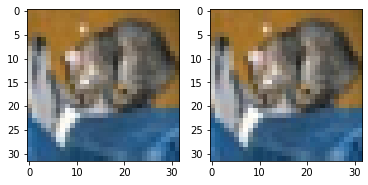

In [154]:
i=0
#i=78
print(f"true class: {cifar_classes[int(tsty[i])]}")
print(f"prediction: {cifar_classes[int(pred.argmax(1)[i])]}, proba: {pred.max(1)[i]}")
print(f"prediction: {cifar_classes[int(advpred.argmax(1)[i])]}, proba: {advpred.max(1)[i]}")

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(tstX[i])
f.add_subplot(1,2, 2)
plt.imshow(a['tst_lip_1_pert'][i])
plt.plot()

In [159]:
from lolip.attacks.torch.projected_gradient_descent import ProjectedGradientDescent
i = 2
n = 200
nb_iter=10
eps = 0.031
attack_model = ProjectedGradientDescent(
    model_fn=model.model,
    norm=np.inf,
    eps=eps,
    eps_iter=eps*2/nb_iter,
    nb_iter=nb_iter,
)
adv_tstX = attack_model.perturb(tstX[:n], tsty[:n])
predpro = model.predict_proba(tstX[:n])
advpro = model.predict_proba(adv_tstX[:n])
proba = np.array([predpro[i][tsty[i]] for i in range(n)])
advproba = np.array([advpro[i][tsty[i]] for i in range(n)])

In [168]:
print(sorted([(p, i) for i, p in enumerate(advproba)])[::-1])

[(3.928364e-19, 38), (2.139491e-20, 50), (6.2324763e-21, 67), (7.5909937e-22, 14), (5.8268816e-22, 11), (2.890054e-23, 56), (2.0332044e-24, 45), (5.753915e-25, 41), (3.278957e-25, 89), (1.7603159e-25, 44), (4.0502673e-26, 23), (3.8533094e-26, 47), (3.400378e-26, 96), (3.983777e-27, 19), (2.5159128e-27, 93), (1.2369445e-27, 95), (7.5774886e-28, 82), (1.7982877e-28, 6), (1.7919399e-28, 76), (7.5623535e-29, 28), (6.4600397e-29, 92), (2.8477258e-29, 13), (6.962432e-30, 62), (4.382583e-30, 98), (4.076206e-30, 39), (3.408397e-30, 79), (7.753089e-31, 60), (6.6937868e-31, 90), (6.2585087e-31, 37), (6.050055e-31, 88), (3.8625567e-31, 80), (3.3014763e-31, 34), (2.4592397e-31, 81), (2.066421e-31, 1), (1.6975366e-31, 40), (5.7094654e-32, 4), (1.2647153e-32, 73), (1.2139842e-32, 69), (1.09526326e-32, 15), (1.0822801e-32, 9), (7.681779e-33, 66), (7.1334875e-33, 33), (5.092126e-33, 71), (3.8350386e-33, 29), (2.8612442e-33, 27), (1.5129782e-33, 77), (1.3103929e-33, 20), (3.4747925e-34, 2), (2.4914444e

[[9.60847202e-31 1.00000000e+00 1.60442974e-27 8.66779592e-30
  5.83278945e-32 8.44278725e-22 7.71061711e-31 1.03557711e-28
  1.10328465e-33 8.09422565e-25]]
true class: ship
prediction: car, proba: 1.0


W0106 13:19:10.995937 140719580231488 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


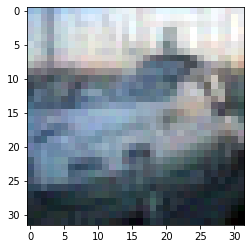

In [158]:
from lolip.attacks.torch.projected_gradient_descent import ProjectedGradientDescent
i = 2
nb_iter=10
eps = 0.031
attack_model = ProjectedGradientDescent(
    model_fn=model.model,
    norm=np.inf,
    eps=eps,
    eps_iter=eps*2/nb_iter,
    nb_iter=nb_iter,
)

adv_tstX = attack_model.perturb(tstX[i:i+1], tsty[i:i+1])
print(model.predict_proba(adv_tstX))
print(f"true class: {cifar_classes[int(tsty[i])]}")
print(f"prediction: {cifar_classes[int(model.predict(adv_tstX)[0])]}, proba: {model.predict_proba(adv_tstX).max(1)[0]}")

plt.imshow(adv_tstX[0])

[[3.9642419e-13 4.6638211e-11 3.3105352e-10 3.0798118e-11 6.5500468e-01
  1.1840269e-06 1.5918528e-12 3.4499472e-01 5.9323409e-14 1.8311993e-11]]
prediction: deer, proba: 0.6550046801567078


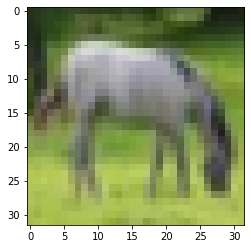

In [111]:
from lolip.attacks.torch.projected_gradient_descent import ProjectedGradientDescent
nb_iter=10
eps = 0.0035
attack_model = ProjectedGradientDescent(
    model_fn=model.model,
    norm=np.inf,
    eps=eps,
    eps_iter=eps*2/nb_iter,
    nb_iter=nb_iter,
)

adv_trnX = attack_model.perturb(trnX[i:i+1], trny[i:i+1])
print(model.predict_proba(adv_trnX))
print(f"prediction: {cifar_classes[int(model.predict(adv_trnX)[0])]}, proba: {model.predict_proba(adv_trnX).max(1)[0]}")

plt.imshow(adv_trnX[0])
#adv_tstX = attack_model.perturb(tstX)
#print((ModelWrapper(model).predict(trnX) == trny).mean())
#print((ModelWrapper(model).predict(adv_trnX) == trny).mean())

In [25]:
Xs = []
for eps in [0.4, 0.6, 0.8, 1.0, 1.2]:
    Xs.append(estimate_local_lip_v2(model, trnX[:10], top_norm=1, btm_norm=np.inf, epsilon=eps))

(array([1.5200e+02, 6.5120e+03, 2.2573e+04, 2.0928e+04, 7.5230e+03,
        1.8900e+03, 3.4400e+02, 6.7000e+01, 8.0000e+00, 2.0000e+00]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.],
       dtype=float32),
 <a list of 10 Patch objects>)

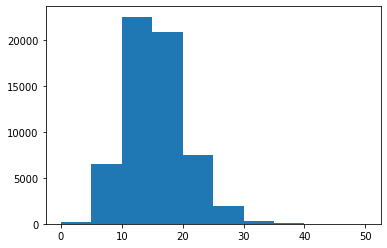

In [22]:
model_path = "./models/pgd-mnist-0.1-trades10ce-tor-CNN001-inf-0.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))

a = joblib.load("./results/experiment03/pgd-mnist-0.1-trades10ce-tor-CNN001-inf-0.pkl")
lip_ = calc_lip(model, trnX, a['trn_lip_1_pert'], top_norm=1, btm_norm=np.inf)
plt.hist(lip_, range=(0, 50))


In [17]:
ModelWrapper(model).predict(trnX)

array([5, 0, 4, ..., 5, 6, 8])

In [16]:
a = joblib.load("results/experiment01/pgd-fashion-0.1-advce-tor-CNN002-inf-0.pkl")
a['history'][-5]


{'epoch': 156,
 'trn_loss': 0.4567526239236196,
 'trn_acc': 0.81165,
 'tst_loss': 0.3531107112646103,
 'tst_acc': 0.8642}

In [11]:
#a = joblib.load("./results/experiment01/pgd-fashion-0.1-advkld-tor-CNN002-inf-0.pkl")
a = joblib.load("./results/experiment01/pgd-svhn-0.031-advce-tor-WRN_40_10-lrem2-inf-0.pkl")
a['trn_acc']

0.9520045865924075

{'epoch': 1, 'trn_loss': 2.14158483795166, 'trn_acc': 0.22592, 'tst_loss': 1.850193497276306, 'tst_acc': 0.3265}


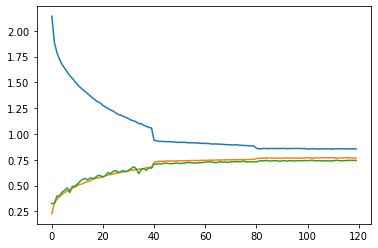

In [5]:
a = joblib.load("./results/experiment01/pgd-cifar10-0.031-aug01-cure14ce-tor-WRN_40_10-inf-0.pkl")
print(a['history'][0])
plt.plot([h['trn_loss'] for h in a['history']])
plt.plot([h['trn_acc'] for h in a['history']])
plt.plot([h['tst_acc'] for h in a['history']])

In [57]:
from scipy.special import kl_div

def kld(p, q):
    return p * np.log(p/q) + (1-p) * np.log((1-p)/(1-q))

def trades(p, advp, beta=1.0):
    return -np.log(p) + beta * kld(advp, p)

def ptrades(p, advp, beta=1.0):
    return -np.log(p) + beta * kld(advp, p) / np.linalg.norm(p - advp, ord=np.inf)

def ce(p):
    return -np.log(p)

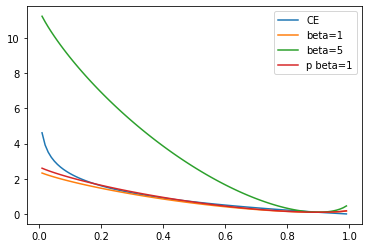

In [61]:
advp = np.arange(1, 101) / 100
plt.plot(advp, ce(advp), label="CE")
plt.plot(advp, trades(p=0.9, advp=advp, beta=1.0), label="beta=1")
plt.plot(advp, trades(p=0.9, advp=advp, beta=5.0), label="beta=5")
plt.plot(advp, ptrades(p=0.9, advp=advp, beta=1.0), label="p beta=1")
#plt.plot(advp, trades(p=0.95, advp=advp, beta=1.0), label="beta=5")
plt.legend()

/home/arbiter/.pyenv/versions/3.7.4/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/arbiter/.pyenv/versions/3.7.4/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


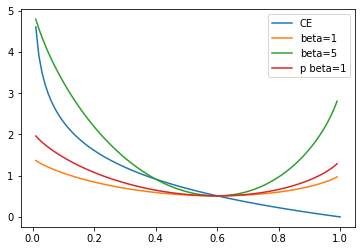

In [64]:
advp = np.arange(1, 101) / 100
plt.plot(advp, ce(advp), label="CE")
plt.plot(advp, trades(p=0.6, advp=advp, beta=1.0), label="beta=1")
plt.plot(advp, trades(p=0.6, advp=advp, beta=5.0), label="beta=5")
plt.plot(advp, ptrades(p=0.6, advp=advp, beta=1.0), label="p beta=1")

#plt.plot(advp, trades(p=0.95, advp=advp, beta=1.0), label="beta=5")
plt.legend()

In [ ]:
def plot_boundary(xx)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='black', s=25)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               alpha=0.6, edgecolors='black', s=25)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

In [ ]:
auto_var.set_variable_value("random_seed", 0)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", "halfmoon-1000-0.25")
model = TorchModel(lbl_enc=None, n_features=(2, ), n_classes=2, architecture="MLP", epochs=60, learning_rate=1e-2)
_ = model.fit(trnX, trny, verbose=0)

In [7]:
trnX.shape
tstX.shape

(750,)